## Root Finding

Root finding refers to the general problem of searching for a solution or solutions $x$ of equations $F(x)=0$.

We already considered examples of this, when we looked at functions of the form $f'(x)=0$ where we were determining minima (or maxima). These can also be cast in the form $f'(x) = F(x) = 0$.

For quadratic polynomials there is a straightforward expression for the roots, and similar (though increasingly much more complicated) expressions exist for ones of order 3 and 4.

We will focus on the bisection method, Newton's method and Brent's method, since they are quite representative of the algoritms available. As well as reading the python documentation, e.g. from scipy, here are a couple of resources that are quite helpful:

https://www.brianheinold.net/notes/An_Intuitive_Guide_to_Numerical_Methods_Heinold.pdf

https://computingskillset.com/category/solving-equations/

Let us motivate seeking roots with an example from physics:
consider the Planck function that describes black-body electromagnetic radiation. Here we cast this as a function of wavelength and temperature:

$B(\lambda,T) =\frac{2 hc^2}{\lambda^5}\frac{1}{ e^{\frac{hc}{\lambda kT}}-1}$

where $h, c, k$ are the Planck const, speed of light and Boltzmann const respectively. $T, \lambda$ are the effective black-body temperature and wavelength of radiation respectively.

For a source of a particular $T$, at what wavelength is the spectral radiance $B$ a maximum? Instead of using an algorithm to directly determine the maximum, we are going to differentiate $B$ with respect to $\lambda$ and then solve for the root of that equation.

First of all, plot the function. Let us take an example with T=5800K... This is roughly the effective temperature of the sun, when modeled as a black body emitter.

The function is maximised where $dB/d\lambda = 0$; we could  use a substitution $x = hc/\lambda kT$ and work through analytically, or just use sympy on the full expression as in the cell after next. We also plot this derivative.

In [2]:
import numpy as np
import scipy.constants as const
import scipy.optimize as opt
import matplotlib.pyplot as plt

pi=const.pi
c=const.c
h=const.h
k=const.k

def planck(lam,T):
    numer=2*h*c*c/(lam**5)
    denom=np.exp((h*c)/(lam*k*T))-1.0
    return numer/denom

lam = np.linspace(1E-7,3E-6,1000)

specsun=planck(lam,5800)

fig,ax=plt.subplots()
ax.plot(lam,specsun)
ax.set(xlabel= '$\lambda[m]$', ylabel='$B_{\lambda} \, [\mathrm{W \, m^{-3} \, ster^{-1}}]$')
ax.grid()
plt.show()

# I got this expression using sympy - pasting here and using 
# substitute np.exp
def planckdiff(l,T):
    return c**2*h*(-10.0/(l**6*(np.exp(c*h/(T*k*l)) - 1.0)) + 2.0*c*h*np.exp(c*h/(T*k*l))/(T*k*l**7*(np.exp(c*h/(T*k*l)) - 1.0)**2))


l = np.linspace(1E-7,3E-6,1000)

specsundiff=planckdiff(l,5800)

fig,ax=plt.subplots()
ax.plot(l,specsundiff)
ax.set(xlabel= '$\lambda[m]$', ylabel='$dB/d\lambda$')
ax.grid()
plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

The cell below uses sympy to do the differentiation. I took the output and pasted it in the cell above.

In [3]:
import sympy as symp

h, c, k, T, x, l = symp.symbols('h c k T x l')

Bdiff1=symp.diff(1.0/(l**5*(symp.exp(h*c/(l*k*T))-1.0)),l)

Bdiff=Bdiff1*2*c*c*h

print(Bdiff)

c**2*h*(-10.0/(l**6*(exp(c*h/(T*k*l)) - 1.0)) + 2.0*c*h*exp(c*h/(T*k*l))/(T*k*l**7*(exp(c*h/(T*k*l)) - 1.0)**2))


Comments: Maximum of $B$ is around 0.5E-6 m in the case T=5800K, and this also coincides with zero of $dB/d\lambda$. 

NB It is good to graph functions to check whether e.g. there are multiple roots or singularities and also that the numerical solutions that we get for root(s) look OK!

Now to solve the black body problem a bit more accurately... there are lots of different methods that can be used - here we will consider a few examples - bisection algorithm, Newton's method and Brent's method.

NB As. mentioned earlier, this particular problem could also be solved by reversing the sign of $B$ and directly determining a minimum (using gradient descent etc)... But we want to illustrate root finding in general, and will also apply it to other problems! 

This might sound obvious but the first thing to do is to recast any problem into the form $F(x)=0$; e.g. if I have $3sin(x^2)-4cos(x.exp(x/10))= 2$
and need to find the roots, I need to write $3sin(x^2)-4cos(x.exp(x/10))-2=0$.

ALGORITHM 1: Bisection algorithm

As we discussed in class, this algorithm proceeds as follows:

1) Given that two points a and b bracket a root means F(a) and F(b) have opposite signs. Take the point half way between them: h = (a+b)/2, and evaluate F(h).

2) If F(h) is within some specified tolerance of 0, then we have found the root - end.

3) If not within specified tolerance, check if F(h) and F(a) have opposite signs. If so, there must be a root between x = a and x = h, so set b = h and go back to step 1.

4) If F(h) and F(a) have the same sign, then F(h) and F(b) must have opposite signs (since F(a) and F(b) have opposite signs). Thus there must be a root between h and b, so set a = h and go back to step 1.

We will use a very simple bisection algorithm (relying on a large enough number of iterations and not even setting a tolerance parameter etc.) and apply it first to a couple of simple problems. Then we look at the corresponding bisection algorithm from scipy.optimize.

!Read the documentation for scipy.optimize.bisect!


func root simple algo.  1.7320508062839508
func root scipy algo. root  1.7320508075699763


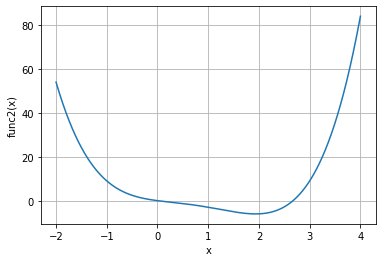

func2, simple algo. root  2.671699881656423
func2, scipy root  2.671699881657787
func2, simple algo. root  1.0004587801479136e-12
func2, scipy root  0.0
simple bisection gives B max at  4.99616026878357e-07  m
scipy optimize bisect gives B max at  4.996170043945313e-07  m


In [4]:
#very simple algorithm; 
#a and b should bracket the root as described above
def bisection(F, a, b, n): 
    for i in range(n):
        h = (a + b) / 2 
        if F(a)*F(h) < 0:
            b=h 
        else:
            a=h 
    return h

#first of all, a simple equation x^2=3 -> x^2-3=0

def func(x):
    return (x**2)-3

# use simple algorithm with 25 iterations - you can experiment with this! 

print('func root simple algo. ',bisection(func, 1,2,25))

#using algorithm directly from scipy

print('func root scipy algo. root ', opt.bisect(func,1,2))

#another polynomial example 

def func2(x):
    return x**4 - 3*x**3 + 2*x**2 -3*x

#note, have to provide values bracketing the root(s)...
#can make a plot - using this way below, or by commenting out
# ax.plot(x,x**4....) and uncommenting other 2 lines indicated
# NB you might in practice have to adjust the range to see functions
# properly!

x=np.linspace(-2,4,1000)
##uncomment for method 2 of plotting
## func2plot=func2(x)
fig, ax = plt.subplots()
ax.plot(x,x**4 - 3*x**3 + 2*x**2 -3*x)
##uncomment for method 2 of plotting
##ax.plot(x,func2plot)
ax.set(xlabel='x', ylabel='func2(x)')
ax.grid()
plt.show()

#there is a trivial root at x=0; note the simple bisection algo. fails
# easily for this root (e.g. if I bracket -1,1), so if we were going further
# it would need to be modified some! Using n=40 for simple algo.
# check options available in opt.bisect!

print('func2, simple algo. root ', bisection(func2, 1,4,40))
print('func2, scipy root ', opt.bisect(func2,1,4))

print('func2, simple algo. root ', bisection(func2, -1,0.9,40))
print('func2, scipy root ', opt.bisect(func2,-1,1))

#now let us apply the simple and scipy routines to
# our black-body problem
pi=const.pi
c=const.c
h=const.h
k=const.k
T=5800

#again set bracketing values by looking at our plot of bB/dl
#(I'm calling lambda -> l) and I'm just restating dB/dl as a
#function of l, with T fixed as above.

def planckdiff2(l):
    return c**2*h*(-10.0/(l**6*(np.exp(c*h/(T*k*l)) - 1.0)) + 2.0*c*h*np.exp(c*h/(T*k*l))/(T*k*l**7*(np.exp(c*h/(T*k*l)) - 1.0)**2))

print('simple bisection gives B max at ', bisection(planckdiff2,0.2e-06,1e-06,25), ' m')
print('scipy optimize bisect gives B max at ', opt.bisect(planckdiff2,0.2e-06,1e-06), ' m')

Note that we have to pick initial bracketing values of $\lambda$ where the sign changes! One way is to plot the function, like we discussed. There is also a "bracket" routine in scipy that will automatically do this part....